# import modules

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import TimeSeriesSplit

# import dataset 

In [76]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime') # set index into datetime
df.index = pd.to_datetime(df.index) 

In [77]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


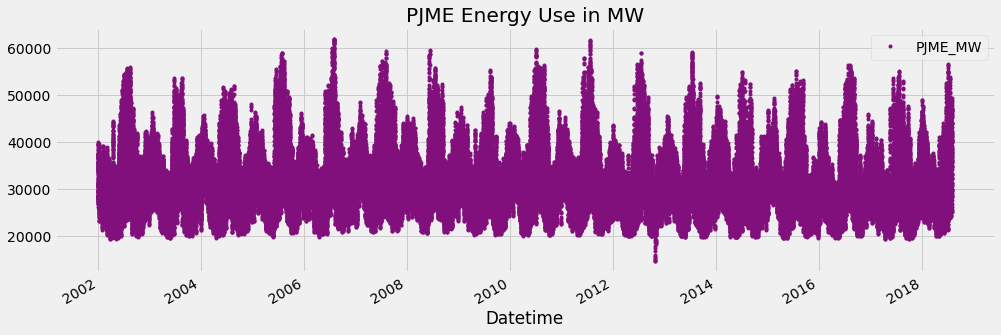

In [79]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[5],
        title='PJME Energy Use in MW')
plt.show()

# Dealing with Outlier

<AxesSubplot:ylabel='Frequency'>

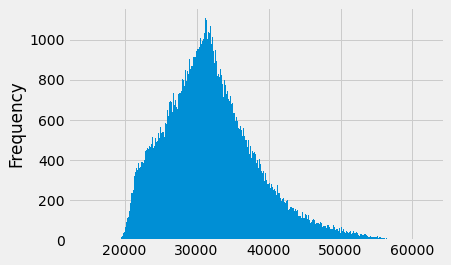

In [42]:
df['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

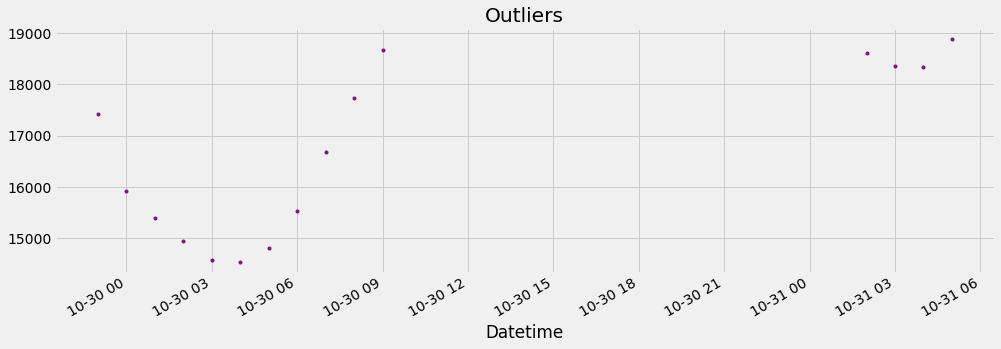

In [43]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [44]:
# use dataset without outliers
df = df.query('PJME_MW > 19_000').copy()

# Splitting data 

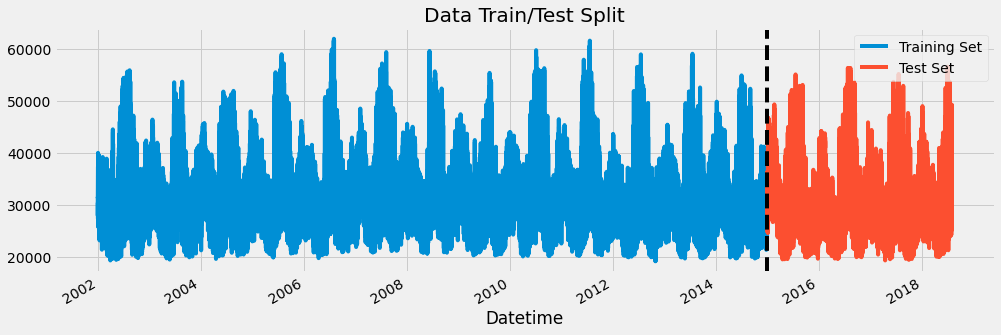

In [45]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

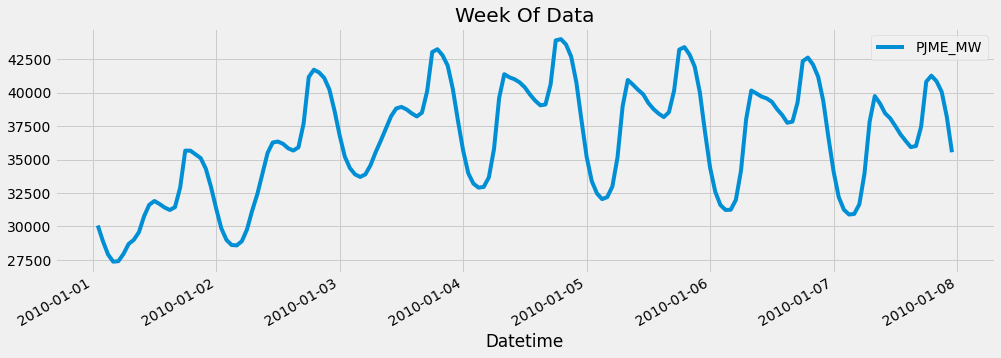

In [46]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

**Insight:**   
Observing the data reveals distinct patterns within each day, characterized by two distinct consumption peaks. This phenomenon is frequently encountered in energy consumption analysis. Moreover, noticeable valleys emerge during the night hours. Another noteworthy aspect is the influence of weekends on the consumption pattern. For instance, a specific day like January 1st, even if it coincides with a holiday, is affected by whether it falls on a weekday or a weekend. This realization paves the way for our subsequent analytical steps.

# Feature Creation (forecasting horizon explained)
**The forecast horizon refers to the period of time into the future for which predictions or forecasts are made. It can range from short-term horizons, typically less than three months, to long-term horizons, which extend beyond two years.**

In [47]:
# make into a function
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour 
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [48]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


# Visualize Feature or Target Relationship

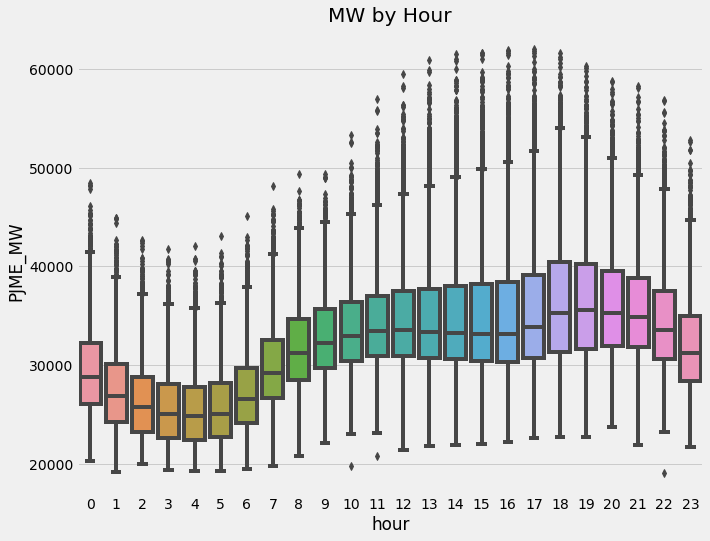

In [49]:
# per day
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

**Insight:**   
Early in the morning there seems to be a dip in energy use and it tends to get higher later in the evening. 

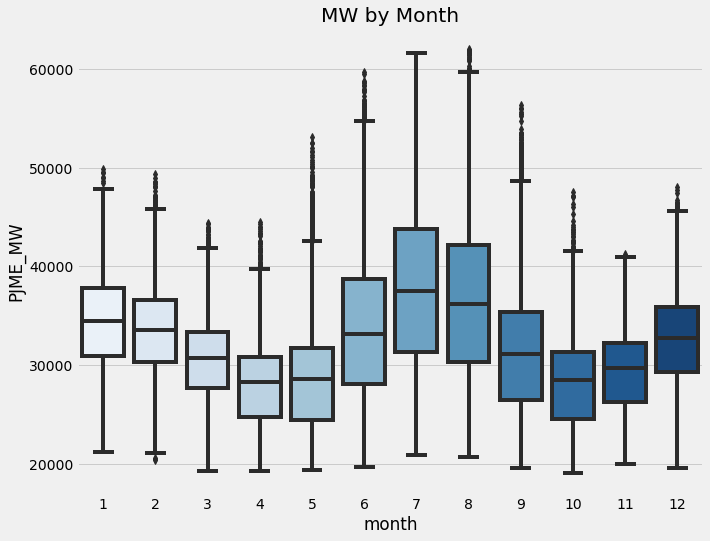

In [50]:
# per month
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

**Insight:**   
the megawatt usage by month tends to peak here two times in the winter season, then in the fall and spring it has lower, and another peak in the middle of summer when everyone's running their AC units. 

# Create Model

In [51]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [52]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01) # lower, to make sure that it doesn't overfit too quickly
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[17:47:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32606.72245	validation_1-rmse:31657.14675
[100]	validation_0-rmse:12582.83149	validation_1-rmse:11744.90898
[200]	validation_0-rmse:5835.12761	validation_1-rmse:5365.22410
[300]	validation_0-rmse:3921.10174	validation_1-rmse:4025.19788
[400]	validation_0-rmse:3446.54672	validation_1-rmse:3858.40506
[500]	validation_0-rmse:3286.26008	validation_1-rmse:3806.07232
[600]	validation_0-rmse:3205.37463	validation_1-rmse:3773.34473
[700]	validation_0-rmse:3150.84414	validation_1-rmse:3753.67981
[800]	validation_0-rmse:3110.29810	validation_1-rmse:3735.87372
[900]	validation_0-rmse:3080.24152	validation_1-rmse:3724.99241
[999]	validation_0-rmse:3052.40889	validation_1-rmse:3722.37762


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Importance

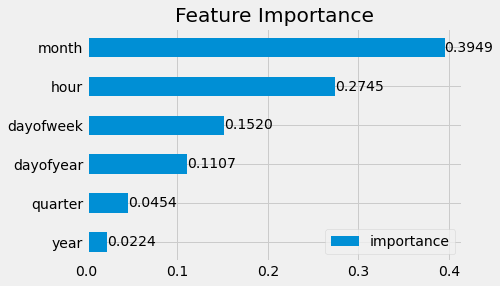

In [53]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi_sorted = fi.sort_values('importance')

# create the horizontal bar plot
ax = fi_sorted.plot(kind='barh', title='Feature Importance')

# annotate the bars with the importance values
for index, value in enumerate(fi_sorted['importance']):
    ax.text(value, index, f'{value:.4f}', va='center')  # display values on bars

plt.show()

# Forecast on Test

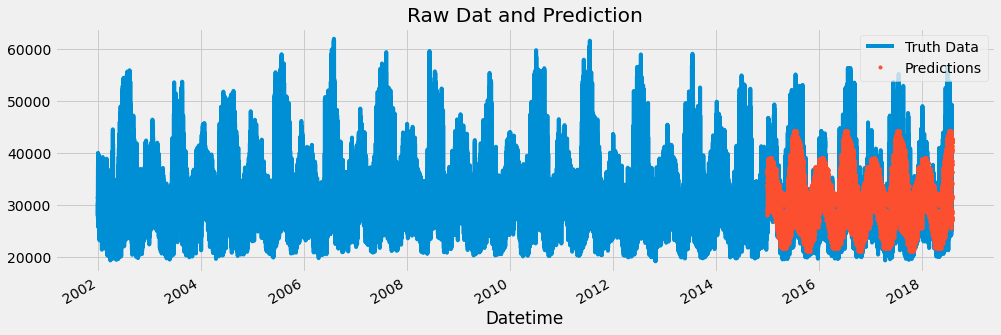

In [54]:
# see our prediction plotted on top of the training dataset
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

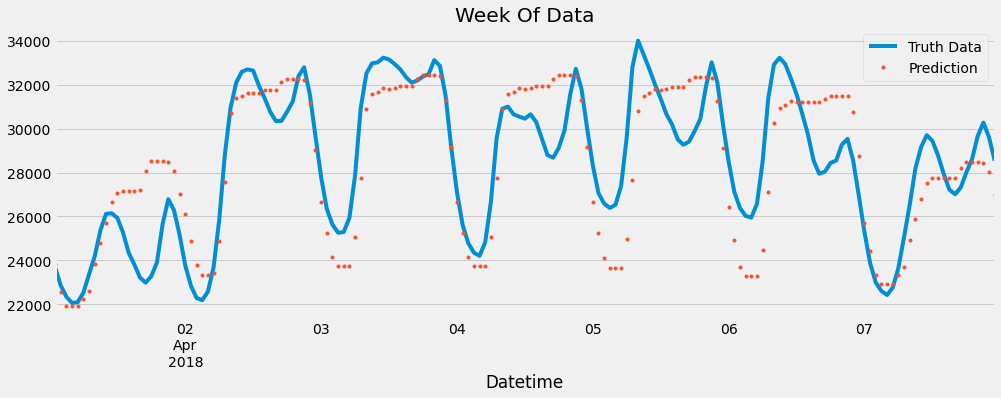

In [55]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

**Insight:**   
The model's performance isn't flawless, leaving room for significant enhancements. One avenue for improvement lies in refining the parameter settings. Currently, the model has not undergone any tuning process. An additional avenue involves incorporating features tailored to specific days within the year, such as holidays. These features could influence energy consumption predictions by accounting for potential increases or decreases on those particular days. Notably, our predictions on the test set for this week align with the expected trend – fluctuating with rises and falls, and exhibiting dips during nighttime hours. This alignment underscores the model's ability to capture these patterns.

# Score (RMSE)

In [56]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3722.31


**To improve this model, we would reduce that score**

# Calculate Error

**look at the worst and best predicted days**

In [57]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date

# worst predicted day
print('Worst Predicted Days')
print(test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10))

print('')

# best predicted days
print('Best Predicted Days')
print(test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10))

Worst Predicted Days
date
2016-08-13    12806.291016
2016-08-14    12743.031169
2016-09-10    11402.480062
2015-02-20    11021.271810
2016-09-09    10848.322998
2018-01-06    10466.624023
2016-08-12    10111.824219
2015-02-21     9922.573975
2015-02-16     9856.599528
2018-01-07     9694.609945
Name: error, dtype: float64

Best Predicted Days
date
2017-10-24    322.859131
2015-10-28    409.960531
2016-10-27    530.303223
2017-10-15    544.775309
2015-05-06    558.571859
2018-05-16    573.304443
2015-11-06    669.838216
2017-04-07    672.190511
2016-09-16    678.153646
2015-10-03    687.152425
Name: error, dtype: float64


# Another Step of Forecasting (more advance)

## 1) Time series cross validation

In [58]:
tss = TimeSeriesSplit(n_splits=5, 
                      test_size=24*365*1, 
                      gap=24) # between the training and the validation set
df = df.sort_index()

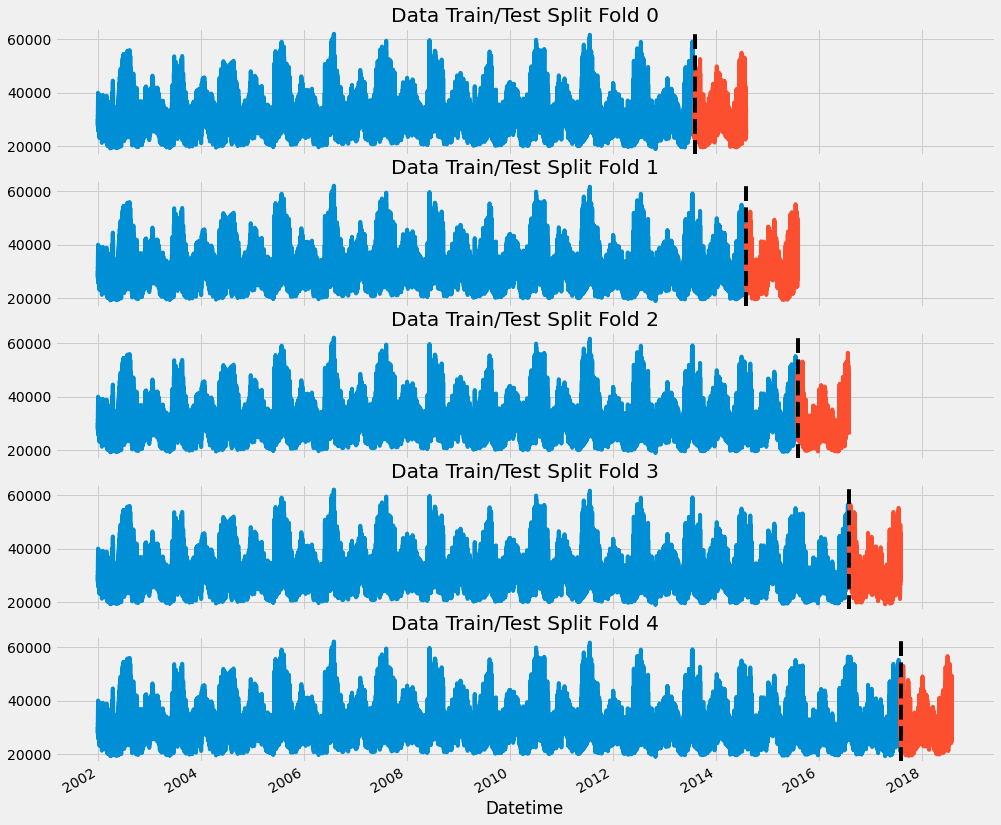

In [59]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True) # x axis is the same

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

**Insight:**   
We can repeat this process five times without any issues, where we test each of the last five years separately. It's important to follow this approach because if we were to just remove the first year and train the model on data after that, it could inadvertently introduce information about our target variable into the validation data. This could lead to data leakage during cross-validation, which we want to avoid. The method we're using ensures a more reliable validation process. This approach is particularly effective when dealing with a lot of time series data, although this may not always be the case. When such data is available, this type of cross-validation is advantageous.

## 2) Lag Features 
**What was the target (x) days in the past?**

In [60]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [61]:
df = add_lags(df)

In [62]:
# train using cross validation
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[17:47:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.30381	validation_1-rmse:31956.18912
[100]	validation_0-rmse:12532.08851	validation_1-rmse:11907.28743
[200]	validation_0-rmse:5743.63141	validation_1-rmse:5355.87526
[300]	validation_0-rmse:3866.68176	validation_1-rmse:3890.94882
[400]	validation_0-rmse:3429.68951	validation_1-rmse:3752.67972
[449]	validation_0-rmse:3356.69575	validation_1-rmse:3758.58399
[17:48:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32671.76435	validation_1-rmse:32142.13257
[100]	validation_0-rmse:12513.14073	validation_1-rmse:12225.51268
[200]	validation_0-rms

In [64]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3749.8536
Fold scores:[3752.67972535384, 3439.9797410456126, 3473.335331082484, 4089.393008070547, 3993.8801185144675]


## 3) Predicting the future
**we need an empty dataframe for future data ranges.**

In [65]:
# retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500, # after 500 iterations there's a chance that it might be overfitting
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[17:52:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.49915
[100]	validation_0-rmse:12426.33494
[200]	validation_0-rmse:5751.05496
[300]	validation_0-rmse:3969.60349
[400]	validation_0-rmse:3568.77505
[499]	validation_0-rmse:3454.87560


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [66]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [67]:
# create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True # create new column
df['isFuture'] = False 
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [68]:
future_w_features = df_and_future.query('isFuture').copy()

In [69]:
# predict future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

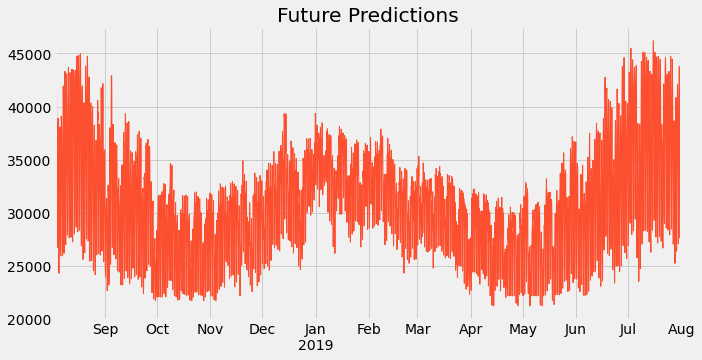

In [72]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()